In this exercise, we will address Machine translation task by utilizing Neural networks. We will compare the performance of RNN and Transformer for this task

# Import libs

In [1]:
import os
from tokenizers import Tokenizer, pre_tokenizers, trainers, models
from datasets import load_dataset
from transformers import PreTrainedTokenizerFast

import torch
import torch.nn as nn
from transformers import PreTrainedModel, PretrainedConfig
from transformers import Trainer, TrainingArguments

# Data

## Load data

In [2]:
ds = load_dataset('thainq107/iwslt2015-en-vi')

In [3]:
print(len(ds['train']))
print(len(ds['validation']))
print(len(ds['test']))
print(ds['train'][0])
print(ds['train'][1])

133317
1268
1268
{'en': 'Rachel Pike : The science behind a climate headline', 'vi': 'Khoa học đằng sau một tiêu đề về khí hậu'}
{'en': 'In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .', 'vi': 'Trong 4 phút , chuyên gia hoá học khí quyển Rachel Pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu , cùng với đoàn nghiên cứu của mình -- hàng ngàn người đã cống hiến cho dự án này -- một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt .'}


## Tokenizer

In [3]:
tokenizer_en = Tokenizer(models.WordLevel(unk_token="<unk>"))
tokenizer_vi = Tokenizer(models.WordLevel(unk_token="<unk>"))

tokenizer_en.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer_vi.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.WordLevelTrainer(
    vocab_size=15000,
    special_tokens=["<pad>", "<unk>", "<bos>", "<eos>"],
    min_frequency=2,
)

tokenizer_en.train_from_iterator(ds['train']['en'], trainer=trainer)
tokenizer_vi.train_from_iterator(ds['train']['vi'], trainer=trainer)

tokenizer_en.save("tokenizer_en.json")
tokenizer_vi.save("tokenizer_vi.json")

## Encoding

In [4]:
MAX_LENGTH = 75

tokenizer_en = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer_en.json",
    bos_token="<bos>",
    eos_token="<eos>",
    pad_token="<pad>",
    unk_token="<unk>",
)

tokenizer_vi = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer_vi.json",
    bos_token="<bos>",
    eos_token="<eos>",
    pad_token="<pad>",
    unk_token="<unk>",
)

def preprocess_function(examples):
    src_texts = examples ["en"]
    tgt_texts = ["<bos> " + sent + "<eos>" for sent in examples ["vi"]]

    src_encodings = tokenizer_en(src_texts, truncation=True, padding="max_length", max_length=MAX_LENGTH)
    tgt_encodings = tokenizer_vi(tgt_texts, truncation=True, padding="max_length", max_length=MAX_LENGTH)

    return {
        'input_ids': src_encodings['input_ids'],
        'labels': tgt_encodings['input_ids'],
    }

preprocessed_ds = ds.map(
    preprocess_function,
    batched=True,
)

In [7]:
print(preprocessed_ds['train'][0])

{'en': 'Rachel Pike : The science behind a climate headline', 'vi': 'Khoa học đằng sau một tiêu đề về khí hậu', 'input_ids': [6675, 1, 57, 60, 339, 604, 13, 744, 5643, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [2, 1960, 66, 1157, 131, 8, 376, 113, 38, 417, 735, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


# Modeling

## RNN

In [8]:
class Seq2SeqRNNConfig(PretrainedConfig):
    def __init__(self, 
                 vocab_size_src=10000, 
                 vocab_size_tgt=10000,
                 embedding_dim=128,
                 hidden_size=128,
                 dropout=0.1,
                **kwargs):
        super().__init__(**kwargs)
        self.vocab_size_src = vocab_size_src
        self.vocab_size_tgt = vocab_size_tgt
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.dropout = dropout

class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, dropout_p =0.1):
        super(EncoderRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_size = hidden_size

    def forward(self, x):
        embedded = self.dropout(self.embedding(x)) # (batch_size, seq_len, embedding_dim)
        output, hidden = self.gru(embedded) # (batch_size, seq_len, hidden_size), (batch_size, hidden_size)
        return output, hidden
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_dim, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded, hidden)
        output = self.fc(output)
        return output, hidden

In [9]:
class Seq2SeqRNN(PreTrainedModel):
    config_class = Seq2SeqRNNConfig

    def __init__(self, config, tokenizer_en):
        super(Seq2SeqRNN, self).__init__(config)
        self.encoder = EncoderRNN(config.vocab_size_src, config.embedding_dim, config.hidden_size, config.dropout)
        self.decoder = DecoderRNN(config.hidden_size, config.embedding_dim, config.vocab_size_tgt)
        self.BOS_IDX = tokenizer_en.bos_token_id
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_en.pad_token_id)

    def forward(self, input_ids, labels):
        # Mask for the decoder input
        batch_size, seq_len = labels.shape
        decoder_input = torch.full((batch_size, 1), self.BOS_IDX, dtype=torch.long).to(input_ids.device)
        encoder_output, decoder_hidden = self.encoder(input_ids)
        decoder_outputs = []

        for i in range(seq_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            decoder_input = labels[:, i].unsqueeze(1)

        logits = torch.cat(decoder_outputs, dim=1)
        loss = self.loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
        return {
            "loss": loss,
            "logits": logits,
        }

## Transformer

In [5]:
def generate_square_subsequent_mask(sz, device):
    """Generate a square mask for the sequence."""
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    return mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]
    device = src.device

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device).to(torch.bool)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)
    src_padding_mask = (src == 0)
    tgt_padding_mask = (tgt == 0)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [7]:
class Seq2SegTransformerConfig(PretrainedConfig):
    def __init__(self, 
                 vocab_size_src=10000, 
                 vocab_size_tgt=10000,
                 d_model=128,
                 n_heads=4,
                 n_layers=2,
                 dropout=0.1,
                 max_seq_len=75,
                **kwargs):
        super().__init__(**kwargs)
        self.vocab_size_src = vocab_size_src
        self.vocab_size_tgt = vocab_size_tgt
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.dropout = dropout
        self.max_seq_len = max_seq_len
        

class Seq2SeqTransformer(PreTrainedModel):
    config_class = Seq2SegTransformerConfig

    def __init__(self, config, tokenizer_en):
        super(Seq2SeqTransformer, self).__init__(config)
        self.embedding_src = nn.Embedding(config.vocab_size_src, config.d_model)
        self.embedding_tgt = nn.Embedding(config.vocab_size_tgt, config.d_model)

        self.positional_encoding_src = nn.Embedding(config.max_seq_len, config.d_model)
        self.positional_encoding_tgt = nn.Embedding(config.max_seq_len, config.d_model)
        
        self.transformer = nn.Transformer(
            d_model=config.d_model,
            nhead=config.n_heads,
            num_encoder_layers=config.n_layers,
            num_decoder_layers=config.n_layers,
            dropout=config.dropout,
            batch_first=True
        )

        self.generator = nn.Linear(config.d_model, config.vocab_size_tgt)

        self.loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_en.pad_token_id)

    def forward(self, input_ids, labels):
        tgt_input = labels[:, :-1] 
        tgt_output = labels[:, 1:] 
        batch_size, src_seq_len = input_ids.shape
        _, tgt_seq_len = tgt_input.shape

        src_pos = torch.arange(src_seq_len, device=input_ids.device).unsqueeze(0)
        tgt_pos = torch.arange(tgt_seq_len, device=labels.device).unsqueeze(0)

        src_positional_encoding = self.positional_encoding_src(src_pos)
        tgt_positional_encoding = self.positional_encoding_tgt(tgt_pos)

        src_embedding = self.embedding_src(input_ids) + src_positional_encoding
        tgt_embedding = self.embedding_tgt(tgt_input) + tgt_positional_encoding

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(input_ids, tgt_input)
        transformer_output = self.transformer(
            src_embedding, tgt_embedding, src_mask, tgt_mask,
            src_key_padding_mask=src_padding_mask, 
            tgt_key_padding_mask=tgt_padding_mask, 
        )

        logits = self.generator(transformer_output)
        loss = self.loss_fn(logits.permute(0, 2, 1), tgt_output)

        return {
            "loss": loss,
            "logits": logits,
        }
    
    def encode(self, src, src_mask):
        _, src_seq_len = src.shape
        src_pos = torch.arange(src_seq_len, device=src.device).unsqueeze(0)
        src_positional_encoding = self.positional_encoding_src(src_pos)
        src_embedding = self.embedding_src(src) + src_positional_encoding
        return self.transformer.encoder(src_embedding, src_mask)
    
    def decode(self, tgt, memory, tgt_mask):
        _, tgt_seq_len = tgt.shape
        tgt_pos = torch.arange(tgt_seq_len, device=tgt.device).unsqueeze(0)
        tgt_positional_encoding = self.positional_encoding_tgt(tgt_pos)
        tgt_embedding = self.embedding_tgt(tgt) + tgt_positional_encoding
        return self.transformer.decoder(tgt_embedding, memory, tgt_mask)

## Training

## RNN

In [12]:
# RNN Model
config_rnn = Seq2SeqRNNConfig(
    vocab_size_src=tokenizer_en.vocab_size,
    vocab_size_tgt=tokenizer_vi.vocab_size,
)

model_rnn = Seq2SeqRNN(config_rnn, tokenizer_en)

In [13]:
training_args = TrainingArguments(
    output_dir="./rnn-en-vi-machine-translation",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    num_train_epochs=50,
    weight_decay=0.01,
    save_total_limit=1,
)

trainer_rnn = Trainer(
    model=model_rnn,
    args=training_args,
    train_dataset=preprocessed_ds['train'],
    eval_dataset=preprocessed_ds['validation'],
)

trainer_rnn.train()

Epoch,Training Loss,Validation Loss
1,9.412700,9.248562
2,8.726400,7.707343
3,7.071500,6.691533
4,6.482600,6.353558
5,6.249100,6.194564
6,6.132700,6.108778
7,6.065200,6.054597
8,6.019800,6.015637
9,5.985100,5.985086
10,5.956100,5.958481


TrainOutput(global_step=13050, training_loss=5.7601323129938935, metrics={'train_runtime': 1998.7997, 'train_samples_per_second': 3334.926, 'train_steps_per_second': 6.529, 'total_flos': 5889418457850000.0, 'train_loss': 5.7601323129938935, 'epoch': 50.0})

## Transformer

In [8]:
# Transformer Model
config_transformer = Seq2SegTransformerConfig(
    vocab_size_src=tokenizer_en.vocab_size,
    vocab_size_tgt=tokenizer_vi.vocab_size,
)
model_transformer = Seq2SeqTransformer(config_transformer, tokenizer_en)

In [9]:
training_args = TrainingArguments(
    output_dir="./transformer-en-vi-machine-translation",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    num_train_epochs=50,
    weight_decay=0.01,
    save_total_limit=1,
)

trainer_transformer = Trainer(
    model=model_transformer,
    args=training_args,
    train_dataset=preprocessed_ds['train'],
    eval_dataset=preprocessed_ds['validation'],
)

trainer_transformer.train()

Epoch,Training Loss,Validation Loss
1,8.801300,8.169316
2,7.738700,7.286417
3,7.013000,6.703595
4,6.549200,6.357045
5,6.273700,6.141551
6,6.094900,5.992017
7,5.964900,5.876191
8,5.858800,5.776066
9,5.763900,5.683628
10,5.676500,5.599006


TrainOutput(global_step=13050, training_loss=5.256493476487668, metrics={'train_runtime': 3501.8007, 'train_samples_per_second': 1903.549, 'train_steps_per_second': 3.727, 'total_flos': 1.280978660889e+16, 'train_loss': 5.256493476487668, 'epoch': 50.0})

# Plotting

## RNN

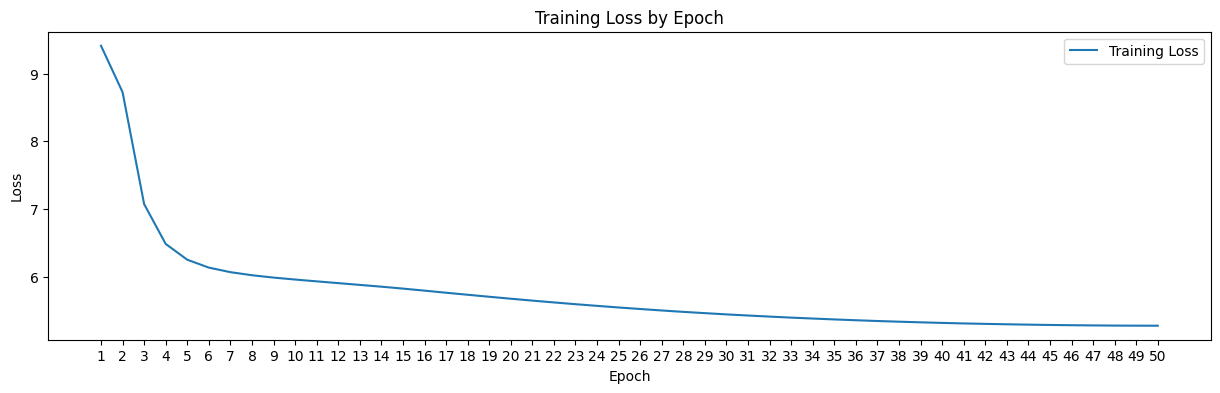

In [25]:
import matplotlib.pyplot as plt

# Extract logs recorded per epoch
logs = trainer_rnn.state.log_history
epochs = [log['epoch'] for log in logs if 'loss' in log and 'epoch' in log]
losses = [log['loss'] for log in logs if 'loss' in log and 'epoch' in log]

# Plot
plt.figure(figsize=(15, 4))
plt.plot(epochs, losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss by Epoch")
plt.xticks(sorted(set(epochs)))
plt.legend()
plt.show()

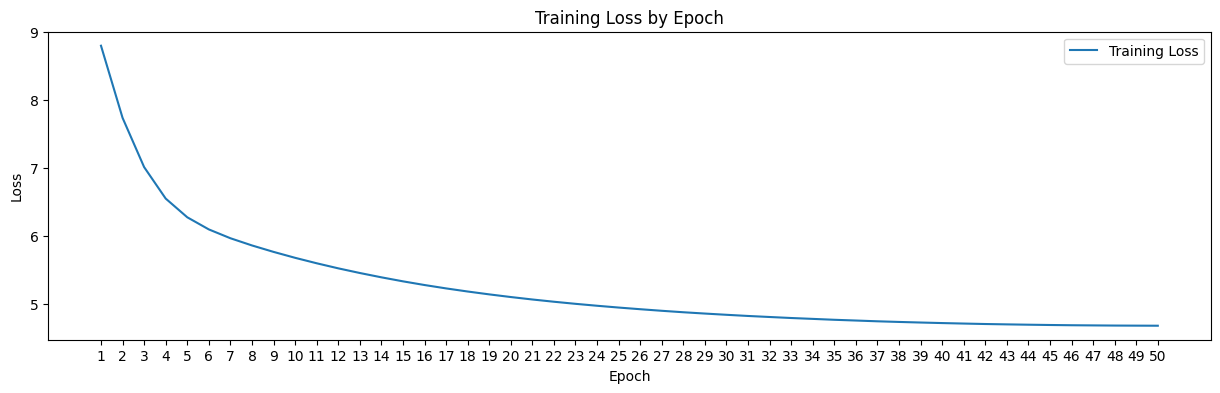

In [10]:
import matplotlib.pyplot as plt

# Extract logs recorded per epoch
logs = trainer_transformer.state.log_history
epochs = [log['epoch'] for log in logs if 'loss' in log and 'epoch' in log]
losses = [log['loss'] for log in logs if 'loss' in log and 'epoch' in log]

# Plot
plt.figure(figsize=(15, 4))
plt.plot(epochs, losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss by Epoch")
plt.xticks(sorted(set(epochs)))
plt.legend()
plt.show()

## Transformer

# Inference

In [17]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, device="cpu"):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1), device)
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        prob = model.generator(out[:, -1, :]) # LM Head
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word[-1].item() # index

        ys = torch.cat([ys,torch.ones(1, 1).type_as(
            src.data).fill_(next_word)], dim=1)
        if next_word == 3: #EOS : 3
            break
    return ys

def translate(model, src_sentence, device):
    model.eval()
    input_ids = tokenizer_en([src_sentence], return_tensors='pt')['input_ids'].to(device)
    num_tokens = input_ids.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(device)
    tgt_tokens = greedy_decode(
        model,  input_ids, src_mask, max_len=num_tokens + 5, start_symbol=2, device=device)
    return tokenizer_vi.decode(tgt_tokens.detach().cpu()[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentence = 'I talk to you every day.'
print("Input: ", sentence)
print("Predicted: ", translate(model_transformer, sentence, device))

Input:  I talk to you every day.
Predicted:  <bos> Tôi muốn nói rằng bạn thấy những người khác biệt thể
